In [ ]:
# Import essential Python libraries necessary for numerical computations, 
# matrix operations, sparse linear algebra, and visualization.


import numpy as np
from matplotlib import pyplot
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

from scipy.sparse.linalg import eigsh
from scipy.sparse import csc_matrix

from func1 import sKTO,creat_mesh,fill_C_inv,fill_D


pot_matrix = np.load('./potential.npy')

In [ ]:
# Define the geometry and grid of the two-dimensional domain, 
# specifying width, height, and the number of discretization intervals.

width = 480 #μm
height = 120 #μm
delta = 4 #μm, size of the discretization interval

n_x = width//4 # Number of squares along the x-axis
n_y = height//4 # Number of squares along the y-axis


# Generate the grid of points
x = np.linspace(-width/2, width/2, n_x+1)
y = np.linspace(-height/2, height/2, n_y+1)
xv, yv = np.meshgrid(x, y)

# Creates an instance of the sKTO class, which is used to define the geometry of the superconducting structure.
shape = sKTO() 


# Add superconducting regions to the shape
shape.add_rectangle(origin=[0,16],h =448,v = 32,conducting = True)
shape.add_rectangle(origin=[0,0],h = 32,v = 64,conducting = True)

# Add non-superconducting regions if needed
# shape.add_circle(origin=[0,0],r = 20,conducting = False)

# Creates the mesh for the superconducting structure.
p1,p1_idx,p2 = creat_mesh(width,height,n_x,n_y,shape)
# p1, p2: lists of instances of the Rectangle class which represent the superconducting and non-superconducting rectangles, respectively.
# p1_idx: coordinates of the superconducting rectangles in the mesh.



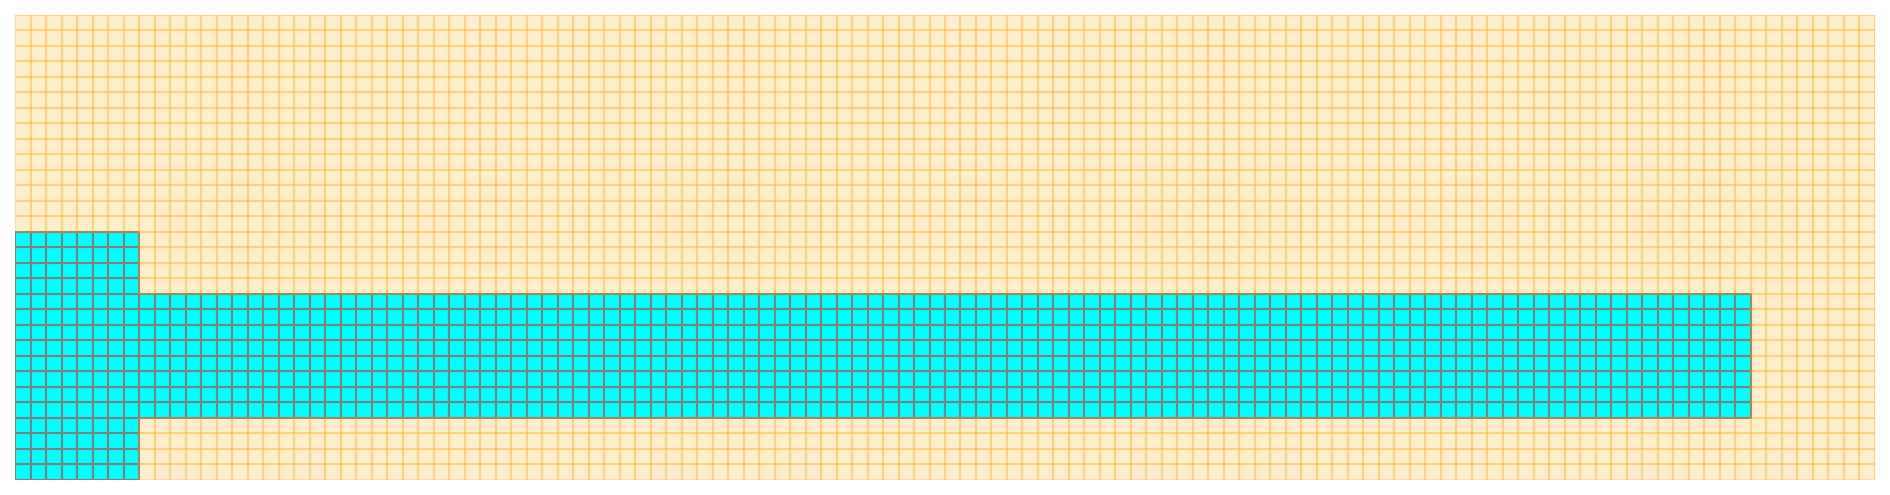

In [7]:
# Plot the geometry and the mesh of the device.
fig, ax = pyplot.subplots()
fig.set_dpi(150)
fig.set_figwidth(16)
fig.set_figheight(9)
pc1 = PatchCollection(p1, edgecolor='grey',facecolor = 'cyan')
ax.add_collection(pc1)
pc2 = PatchCollection(p2, edgecolor='orange',facecolor = 'orange',alpha = 0.2)
ax.add_collection(pc2)




ax.set_xlim([-0.01, width+0.01])
ax.set_ylim([-0.01, height+0.01])
ax.set_aspect('equal')  # Ensure squares are not distorted
ax.axis('off')

pyplot.show()

Solve the eigenmode of the superconducting device from the equation of motion:

$$C_{ij}\phi_0\dot{\phi}_j - \sum_{\delta} I_{i,i+\delta} = 0,$$

where $C_{ij}$ is the capacitance matrix and $I_{i,j} = \frac{\phi_0}{L_K}(\phi_i-\phi_j)$ is the current flowing from node $j$ to node $i$.

In [ ]:
N = len(p1_idx) # Number of superconducting rectangles in the mesh

C_inv = fill_C_inv(N,p1_idx,pot_matrix)
D = fill_D(N,p1_idx)

A_sparse = csc_matrix(C_inv@D,dtype='complex64')
eigenvalues, eigenvectors = eigsh(A_sparse, k=4, which='SR')# first 4 eigenvalues

In [9]:
print('first 4 eigenmodes are:'+ str(np.sqrt(eigenvalues/(4*np.pi*4500/2*8.85*10**(-12)*delta*10**(-6)*10**(-9)))/np.pi/2)+"GHz")
print("number of mesh:" +str(len(p1)))

first 4 eigenmodes are:[3.1445212e+06 8.5293126e+08 1.5776607e+09 2.2164936e+09]GHz
number of mesh:960


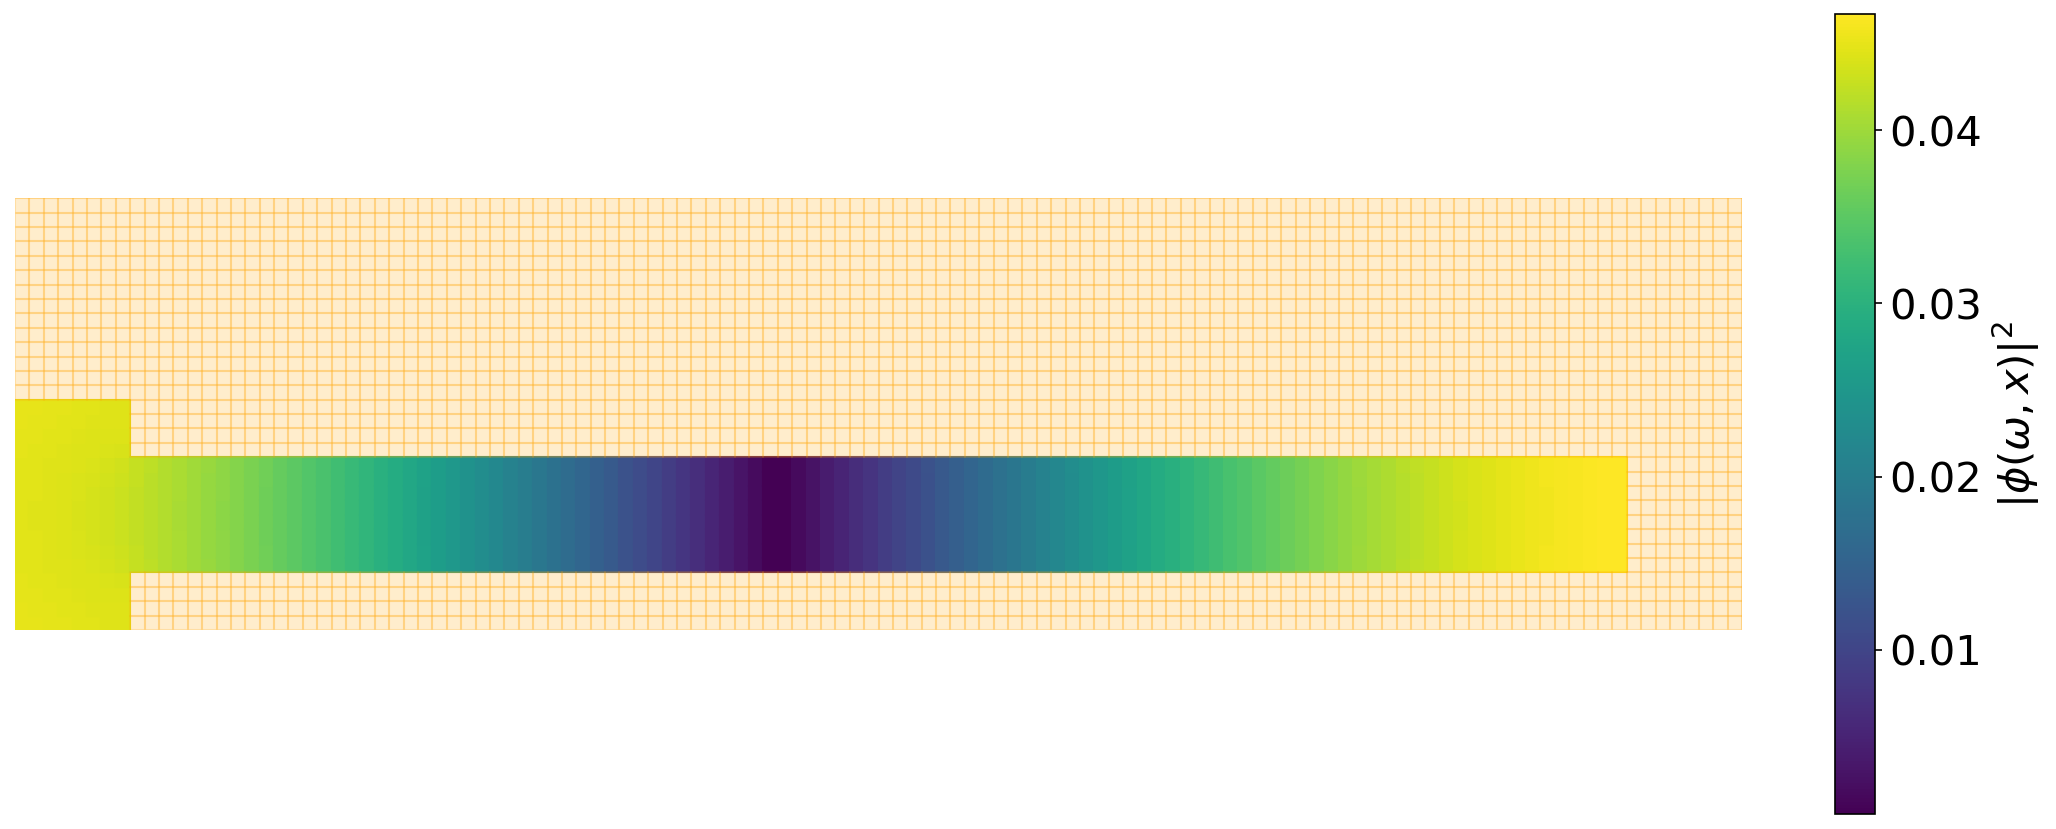

In [10]:
#Plot the first nonzero eigenmode
values = np.abs(eigenvectors[:,1])
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
cmap = cm.viridis

fig, ax = pyplot.subplots()
fig.set_dpi(150)
fig.set_figwidth(16)
fig.set_figheight(9)
pc1 = PatchCollection(p1, edgecolor='none')
ax.add_collection(pc1)
pc2 = PatchCollection(p2, edgecolor='orange',facecolor = 'orange',alpha = 0.2)
ax.add_collection(pc2)

pc1.set_color(cm.viridis(norm(values)))  # Apply colormap through normalization directly


ax.set_xlim([-0.01, width+0.01])
ax.set_ylim([-0.01, height+0.01])
ax.set_aspect('equal')  # Ensure squares are not distorted
ax.axis('off')
sm = pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = pyplot.colorbar(sm, ax=ax, fraction = 0.0215)
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label = '$|\phi(\omega,x)|^2$' ,size=20) 
pyplot.show()

Comparison between the SLCalc method and the HFSS calculation

In [9]:
#data from the SLCalc method with different numbers of meshes
f1 = [8.6595386e-1,8.5756762e-1,8.5292486e-1,8.5193632e-1,8.5022963e-1,8.4874413e-1,8.4539654e-1]
num_mesh1 = [60,240,960,1500,3840,6000,15360]

#data from HFSS
f2 = [0.8138,0.8267,0.8309,0.8331,0.8346,0.8358,0.8366,0.8372]
num_mesh2 = [11971,15565,20235,26001,33805,42069,54691,62934]

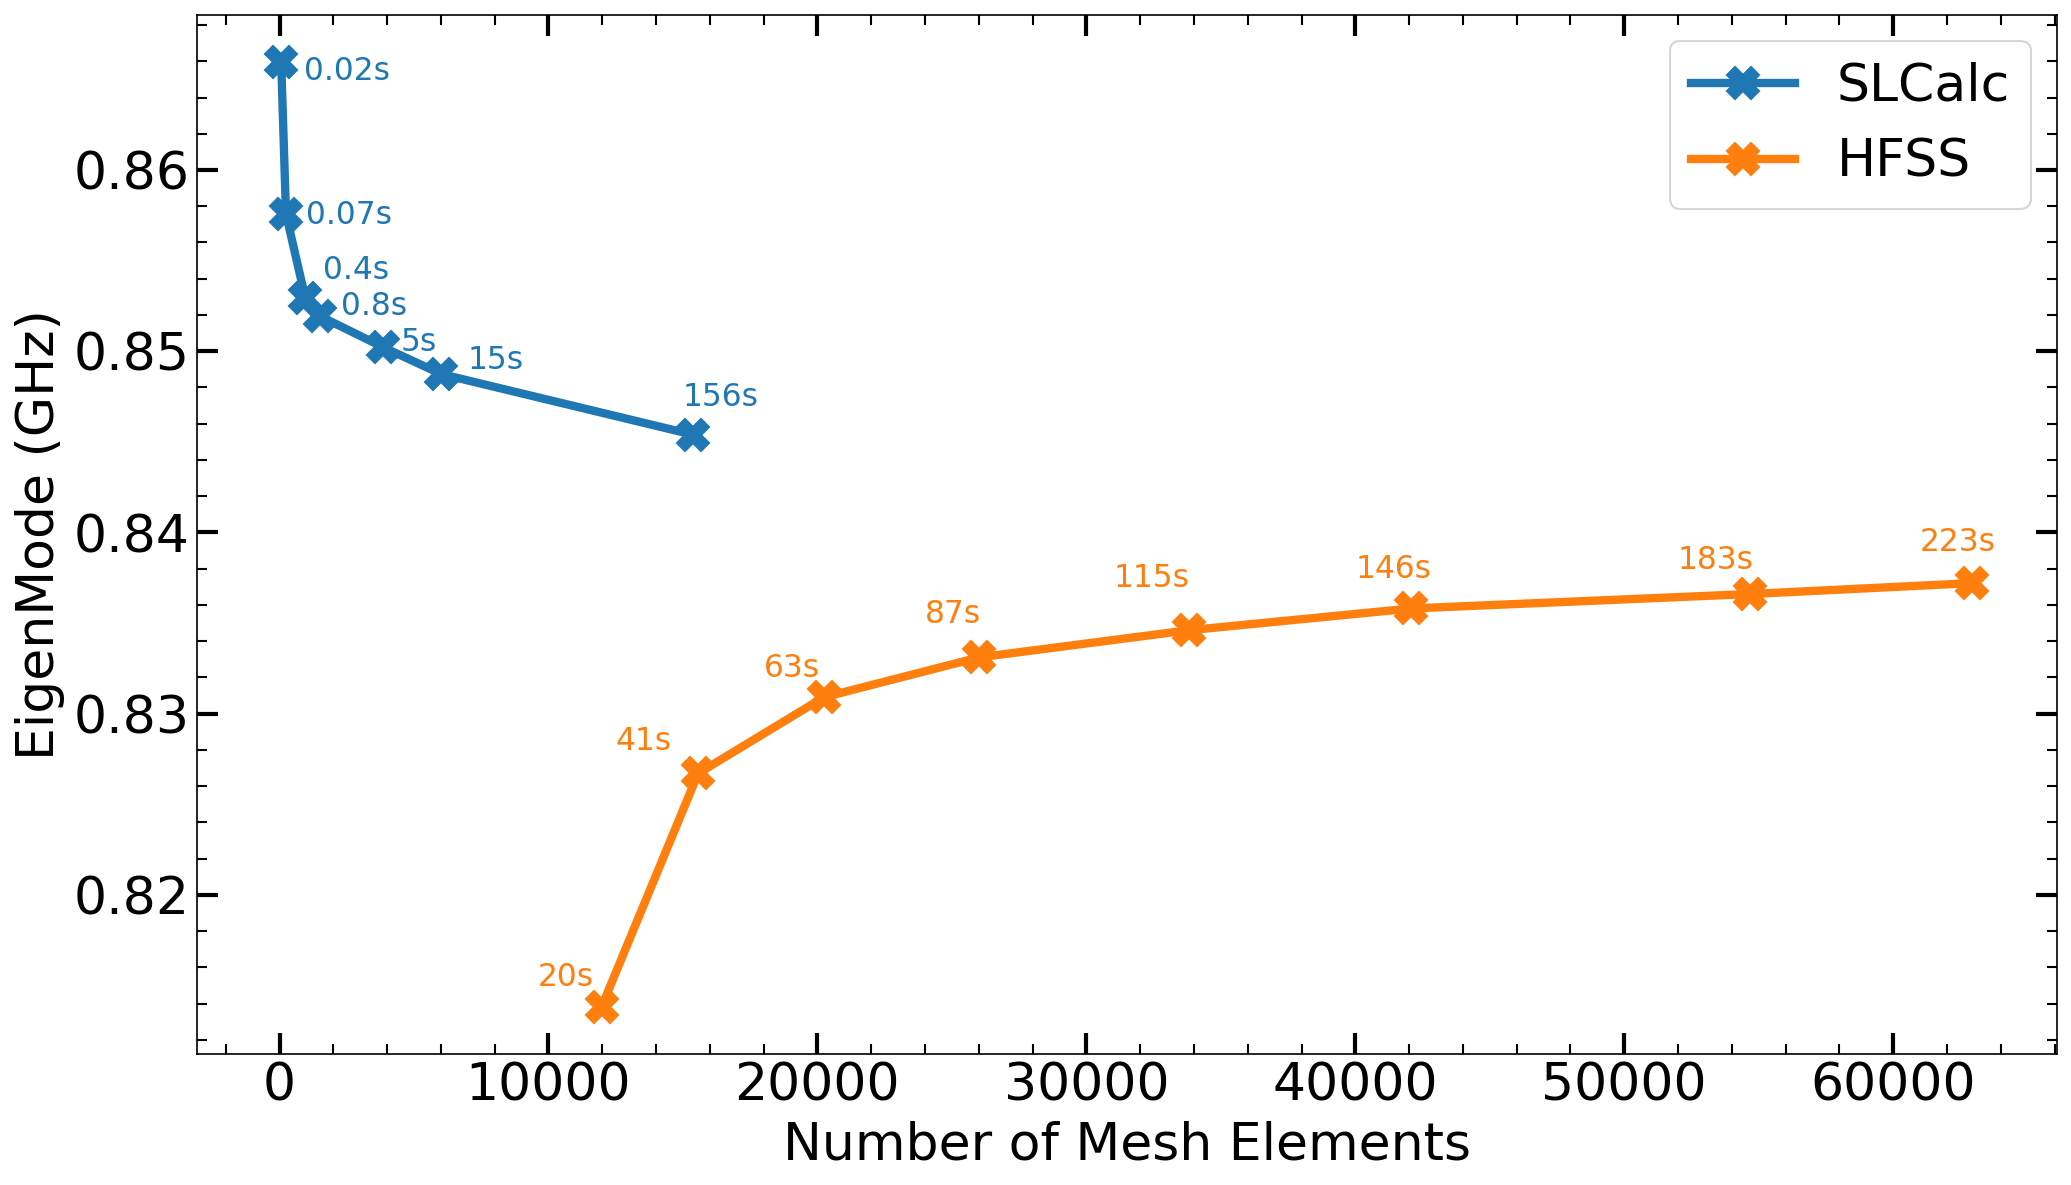

In [10]:
pyplot.figure(figsize=(16,9),dpi = 150)
pyplot.plot(num_mesh1,f1,'X-',linewidth = 4,markersize = 15,label = 'SLCalc')
pyplot.plot(num_mesh2,f2,'X-',linewidth = 4,markersize = 15,label = 'HFSS')

pyplot.xlabel('Number of Mesh Elements',size = 25)
pyplot.ylabel('EigenMode (GHz)',size = 25)
pyplot.xticks(size = 25)
pyplot.yticks(size = 25)

pyplot.tick_params(axis='y', which='major', direction='in', right=True, width=2,length = 10)
pyplot.tick_params(axis='y', which='minor', direction='in', right=True, width=1,length = 5)
pyplot.tick_params(axis='x', which='major', direction='in', top = True, width=2,length = 10)
pyplot.tick_params(axis='x', which='minor', direction='in', top = True, width=1,length = 5)
pyplot.minorticks_on()

pyplot.text(9600,0.815,'20s',color='C1',size = 15)
pyplot.text(12500,0.828,'41s',color='C1',size = 15)
pyplot.text(18000,0.832,'63s',color='C1',size = 15)
pyplot.text(24000,0.835,'87s',color='C1',size = 15)
pyplot.text(31000,0.837,'115s',color='C1',size = 15)
pyplot.text(40000,0.8375,'146s',color='C1',size = 15)
pyplot.text(52000,0.838,'183s',color='C1',size = 15)
pyplot.text(61000,0.839,'223s',color='C1',size = 15)


pyplot.text(900,0.865,'0.02s',color='C0',size = 15)
pyplot.text(1000,0.857,'0.07s',color='C0',size = 15)
pyplot.text(1600,0.854,'0.4s',color='C0',size = 15)
pyplot.text(2300,0.852,'0.8s',color='C0',size = 15)
pyplot.text(4500,0.85,'5s',color='C0',size = 15)
pyplot.text(7000,0.849,'15s',color='C0',size = 15)
pyplot.text(15000,0.847,'156s',color='C0',size = 15)


pyplot.legend(prop={'size':25})
pyplot.savefig('comparison.pdf')
pyplot.show()